In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# GongFou

We first discuss GongFou,
which was an easier version of R2-Dbag.
This solution is due to fortenforge.

In GongFou, you are given a wav file in which the flag is stenographically concealed.
Looking at the wav file in Audacity,
we note that it seems to come in windows of 1024 samples:
![title](res/aud0.png)

Looking at a spectrogram view of the audio with a window size of 1024,
we get:
![title](res/aud1.png)

We note the spectrogram is blocked off nicely into columns,
and that the columns share some common binary structure.
If we interpret high intensities (white) as 1s
and low intensities (gray) as 0s,
we get an 9 by 51 array of bits.
Ignoring the leftmost column, rightmost column,
and bottom row yields a 8 by 49 array of bits.
If we interpret each column of this cropped array as a byte
(with the most significant bit on top)
and convert (fortenforge did this manually) the bytes to characters,
we get:
```python
"TH3 FL4G IS: blaze{I_[4N_H4Z_FUN_W1TH_F0UR13R!:>}"
```

# R2-DBag

Fortenforge and ed1d1a8d worked on this together.

The problem statement is as follows:

>R2-Dbag is listening to what you're telling him and is willing to do what you're asking.

>Note: this challenge is the follow up of GongFou, which should be solved first.

>Note 2: This challenge was tested on Ubuntu 16.04 and works fine. It seems there are problems with some versions of nc though. Try option -q 1 (which fixes the problem in Debian or Kali, that use /bin/nc.traditional).

>`nc r2dbag.420blaze.in 420`

Our team had a hunch that this problem involved
communicating with the server using wav files encoded
like in GongFou.
We attempted to verify this hunch by sending the wav file from GongFou
to the server as seeing what happens.
However, doing this using netcat on MacOS resulted in no response,
which caused us quite a bit of confusion.
We then decided to take Note 2 more seriously
and attempt to netcat on Ubuntu.
Lo and behold we got a response back telling us that
`TH3` was not a valid command type and that the server
expected something starting with `EXEC`.

At this point we worked on building a encoder that would encode a string into a wav.
This was our result:

In [2]:
# Much credit to https://stackoverflow.com/a/33913403
import numpy as np

audio = []
sample_rate = 32768.0

def get_binary(c):
    """takes char c"""
    return bin(ord(c))[2:].zfill(8)

def append_sinewave(data, num_samples=1024):
    """data is a string of '0's and '1's """
    data += "1" # 4.1kHz is always set
    global audio

    pad = 64
    volume = 0.95 / data.count('1') * np.concatenate((np.linspace(0, 1, num_samples // 2 - pad),
                                                      np.linspace(1, 0, num_samples // 2 - pad)))
    volume = np.concatenate((np.zeros(pad), volume, np.zeros(pad)))
    for x in range(int(num_samples)):
        cur = 0
        for idx, f in enumerate(1000 * np.linspace(6.15, 4.1, 9)):
            if data[idx] == '1':
                cur += np.sin(2 * np.pi * f * ( x / sample_rate ))
        audio.append(volume[x] * cur)

message = "EXEC ls"
append_sinewave(8 * "1")
for c in message:
    append_sinewave(get_binary(c))
append_sinewave(8 * "1")

The core functionality is in the `append_sinewave` function,
which appends a byte of data across 1024 samples.
The audio array is simply an array of amplitudes,
and encoding a byte as amplitudes consists
of adding together sin-waves corresponding to each set bit,
which frequencies given by `1000 * np.linspace(6.15, 4.1, 9)`.
This sum was then scaled linearly from 0 amplitude (or volume)
at the start of the window to 0.95 amplitude at the center,
and then back to 0 at the end of the amplitude.
50 samples of silence were also appended to each end of the window.
This scaling and silence was needed
in order to make the produced spectrogram cleaner.

The code above generates the command for ls,
whose waveform looks as follows:

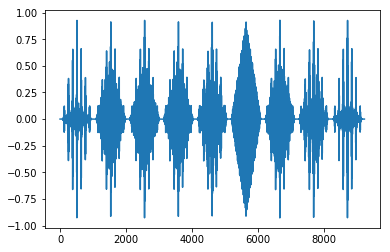

In [3]:
plt.plot(audio);

After saving this waveform as a wav
(see https://stackoverflow.com/a/33913403 for code)
and sending it to the server,
we got a wav file in response.
Thus we began work on a decoder.

We set out to decode R2-Dbag_to_C3POed.wav
(which we already knew the output for)
programmatically.
We began by generating the spectrogram using librosa:

(513, 51)


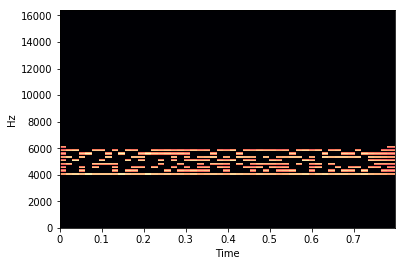

In [4]:
import librosa
from librosa import display

y, sr = librosa.load("res/R2-Dbag_to_C3POed.wav", sr = 32768)
stft = librosa.stft(y, n_fft=1024, hop_length=1024, center=False)
spec = librosa.amplitude_to_db(librosa.magphase(stft)[0], ref=np.max)
print(spec.shape)
librosa.display.specshow(spec, y_axis='linear', x_axis='time', sr=sr);

Next, we had to figure out which rows in the `spec` array corresponded to our desired frequencies.
Plotting the first column of `spec`, which we know is all 1s,
we got:

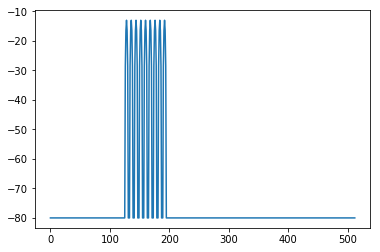

In [5]:
plt.plot(spec[:,0]);

We then obtained the location of the peaks like this:

In [6]:
locs = []
for idx, val in enumerate(spec[:,0]):
    if val > -15:
        locs += [idx]
print(locs)

[128, 136, 144, 152, 160, 168, 176, 184, 192]


Decoding was now easy:

In [7]:
def get_chr(data):
    """data is an array of 0s and 1s"""
    return chr(int(''.join(data), 2))

locs = [136, 144, 152, 160, 168, 176, 184, 192][::-1]
res = ""
for col in range(spec.shape[1]):
    cur = spec[:, col]
    targets = cur[locs]
    data = 8 * ["0"]
    for i in range(8):
        if cur[locs[i]] > -30:
            data[i] = "1"
    c = get_chr(data)
    res += c

print(res)

ÿTH3 FL4G IS: blaze{I_[4N_H4Z_FUN_W1TH_F0UR13R!:>}ÿ


With our encoder and encoder written,
we could now interact with the server.

Running `ls` we got the output:
```
R2-Dbag.py
boot
dev
etc
home
lib
lib64
lib_sound_R2_Dbag.py
<snip>
```
where `<snip>` indicated that the server had truncated the output.

Searching around,
we stumbled upon the directory `home/r2dbag/`,
which contained the files
```
flag1.txt
flag2.txt
flag3.txt
flag4.txt
flag5.txt
flag6.txt
<snip>
```
Running `cat home/r2dbag/flag1.txt` yielded the text `fake`,
which meant the task now was to find the real flag.

`grep`ing this directory for the `{` character,
we arrived at the file `home/r2dbag/r2-dflag_is_here.txt`.
`cat`ing this file produced the flag:
```
blaze{Sp34kinG_R2-Dbag_LanGuaG3_fLu3nTlY}
```